In [1]:
import argparse
import cvxpy as cp
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from pydmd import DMDc

device = "cuda"

In [2]:
def get_rand_mean_sigma(d):
    mu        = np.random.rand(d)
    sigma_tmp = np.random.rand(d, d)
    sigma     = np.dot(sigma_tmp, sigma_tmp.transpose())
    return mu, sigma

In [3]:
# distribution parameters need to be fixed for the simulation
mu_G, sigma_G = get_rand_mean_sigma(5)
mu_L, sigma_L = get_rand_mean_sigma(5)
mu_N, sigma_N = get_rand_mean_sigma(5)

# constants to match form of https://www.sciencedirect.com/science/article/pii/S1877705814011771?ref=pdf_download&fr=RR-2&rr=875e3f6f1afa2b0b
# but not strictly necessary for dynamics generation
g       = 1
U_0     = 1
theta_0 = 0

In [4]:
def generate_dynamics_matrices(num_samples):
    G = np.random.multivariate_normal(mu_G, sigma_G, num_samples)
    L = np.random.multivariate_normal(mu_L, sigma_L, num_samples)
    N = np.random.multivariate_normal(mu_N, sigma_N, num_samples)
    
    final_row = np.ones((G.shape[0], 4))
    final_row[:,0] = final_row[:,3] = 0
    final_row[:,2] = np.tan(theta_0)

    xs = np.hstack([G, L, N])
    As = np.transpose(np.array([
        np.hstack([G[:,:3], np.ones((G.shape[0],1)) * (g * np.cos(theta_0))]) / U_0,
        np.hstack([L[:,:3], np.zeros((L.shape[0],1))]),
        np.hstack([N[:,:3], np.zeros((N.shape[0],1))]),
        final_row,
    ]), (1,0,2))

    Bs = np.transpose(np.array([
        G[:,3:] / U_0,
        L[:,3:],
        N[:,3:],
        np.zeros((G.shape[0], 2)),
    ]), (1,0,2))
    
    return xs, (As, Bs)

In [5]:
# m: trajectory length
def generate_system_trajectories(As, Bs, m = 25):
    n = As.shape[-1]
    l = Bs.shape[-1]

    x0 = np.random.random((n, 1))
    u = np.random.rand(l, m - 1) - .5

    x0 = np.tile(x0, reps=(As.shape[0],1,1)).astype(np.float32)
    u  = np.tile(u,  reps=(Bs.shape[0],1,1)).astype(np.float32)

    snapshots = [x0]

    for i in range(m - 1):
        snapshots.append(As @ snapshots[i] + Bs @ u[:, :, i:i+1])
    snapshots = np.array(snapshots).T
    return {'snapshots': snapshots, 'u': u, 'B': Bs, 'A': As}

In [6]:
def estimate_dynamics_matrices(system):
    mb_size = system["A"].shape[0]
    A_hats, B_hats = [], []
    for i in range(mb_size):
        dmdc = DMDc(svd_rank=-1, opt=True)
        dmdc.fit(system['snapshots'][:,:,i,:], system['u'][i])
        A_hat, B_hat, _ = dmdc.reconstructed_data() # NOTE: the PyDMD reconstructed_data() function was modified to return the dynamics -- this will *not* work by default
        A_hats.append(np.real(A_hat))
        B_hats.append(np.real(B_hat))
    A_hats = np.array(A_hats).reshape(mb_size, -1)
    B_hats = np.array(B_hats).reshape(mb_size, -1)
    return A_hats, B_hats

In [7]:
def generate_data(n_pts):
    xs, (As, Bs) = generate_dynamics_matrices(n_pts)
    system = generate_system_trajectories(As, Bs, m = 25)
    A_hats, B_hats = estimate_dynamics_matrices(system)
    A_hats, B_hats = A_hats.reshape(As.shape), B_hats.reshape(Bs.shape)

    thresh    = 0.1
    valid_ind = np.where(np.logical_and(
        np.linalg.norm(A_hats - As, ord="fro", axis=(1,2)) < thresh,
        np.linalg.norm(B_hats - Bs, ord="fro", axis=(1,2)) < thresh,
    ))
    xs, As, Bs, A_hats, B_hats = xs[valid_ind], As[valid_ind], Bs[valid_ind], A_hats[valid_ind], B_hats[valid_ind]

    xs             = torch.from_numpy(xs).to(torch.float32).to(device)
    As, Bs         = torch.from_numpy(As).to(torch.float32).to(device), torch.from_numpy(Bs).to(torch.float32).to(device)
    A_hats, B_hats = torch.from_numpy(A_hats).to(torch.float32).to(device), torch.from_numpy(B_hats).to(torch.float32).to(device)

    return xs, (As, Bs), (A_hats, B_hats)

In [8]:
class ContextualLQR(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        
        self.fc_A = nn.Linear(64, 16)
        self.fc_B = nn.Linear(64, 8)
        self.fc_C = nn.Linear(64, 24)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        fc2_x = self.fc2(x)
        x     = F.relu(x + fc2_x)

        fc3_x = self.fc3(x)
        x     = F.relu(x + fc3_x)

        # for predictions of A matrix
        A = self.fc_A(x).reshape((-1,4,4))

        # for predictions of B matrix
        B = self.fc_B(x).reshape((-1,4,2))

        # for predictions of C := [A, B] matrix
        # C = self.fc_C(x).reshape((-1,4,6))
        # return C
        return A, B

In [9]:
import torch.optim as optim

net       = ContextualLQR().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

N_train = 500
xs_train, _, (As_train, Bs_train) = generate_data(N_train)

/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 34704878.20287137. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 17202723482.61361. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 997562159.440599. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 18222495.950896528. Consider preprocessing data, passing in augmented data
matrix, or regularizatio

In [10]:
epochs      = 5_000
batch_size  = 500
num_batches = N_train // batch_size

losses = []
for epoch in range(epochs):  # loop over the dataset multiple times
    rolling_loss = 0
    for i in range(num_batches):
        optimizer.zero_grad()

        x_batch, (A_batch, B_batch) = xs_train[i*batch_size:(i+1)*batch_size], (As_train[i*batch_size:(i+1)*batch_size], Bs_train[i*batch_size:(i+1)*batch_size])
        A_hat_batch, B_hat_batch = net(x_batch)
        
        loss = criterion(A_hat_batch, A_batch) + criterion(B_hat_batch, B_batch)
        
        loss.backward()
        optimizer.step()

        rolling_loss += loss.item()
    losses.append(rolling_loss)
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {rolling_loss}')
print('Finished Training')

[1,     1] loss: 2.7065958976745605
[2,     1] loss: 2.5650596618652344
[3,     1] loss: 2.4338488578796387
[4,     1] loss: 2.3112986087799072
[5,     1] loss: 2.1965065002441406
[6,     1] loss: 2.087836265563965
[7,     1] loss: 1.9845983982086182
[8,     1] loss: 1.8862541913986206
[9,     1] loss: 1.7920005321502686
[10,     1] loss: 1.7015106678009033
[11,     1] loss: 1.6142629384994507
[12,     1] loss: 1.530369520187378
[13,     1] loss: 1.4498538970947266
[14,     1] loss: 1.37300705909729
[15,     1] loss: 1.2999074459075928
[16,     1] loss: 1.2305691242218018
[17,     1] loss: 1.1650784015655518
[18,     1] loss: 1.1031343936920166
[19,     1] loss: 1.0446075201034546
[20,     1] loss: 0.9892774224281311
[21,     1] loss: 0.9370205402374268
[22,     1] loss: 0.8877528309822083
[23,     1] loss: 0.8414429426193237
[24,     1] loss: 0.7982333898544312
[25,     1] loss: 0.758358359336853
[26,     1] loss: 0.721920371055603
[27,     1] loss: 0.6889628171920776
[28,     1] loss

In [20]:
def generate_scores(net, num_samples, get_true_dynamics=False):
    if get_true_dynamics:
        xs, (As, Bs), _ = generate_data(num_samples)
    else:
        xs, _, (As, Bs) = generate_data(num_samples)
    A_hat, B_hat = net(xs)

    C = torch.cat([As, Bs], axis=-1).cpu().detach().numpy()
    C_hat = torch.cat([A_hat, B_hat], axis=-1).cpu().detach().numpy()
    diff = C - C_hat
    return (C, C_hat), np.linalg.norm(diff, ord=2, axis=(1,2))

In [21]:
N_cal, N_test = 200, 200
(cal_C, cal_C_hat),   cal_scores  = generate_scores(net, num_samples=N_cal,  get_true_dynamics=False)
(test_C, test_C_hat), test_scores = generate_scores(net, num_samples=N_test, get_true_dynamics=True)
N_cal, N_test = len(cal_C), len(test_C)

/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 132990.0315989386. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 442839.2055396275. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 403080.4648703027. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/yppatel/anaconda3/envs/operator/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 188552315.7064095. Consider preprocessing data, passing in augmented data
matrix, or regularizatio

Text(0.5, 1.0, '$\\mathrm{Model\\ Calibration}$')

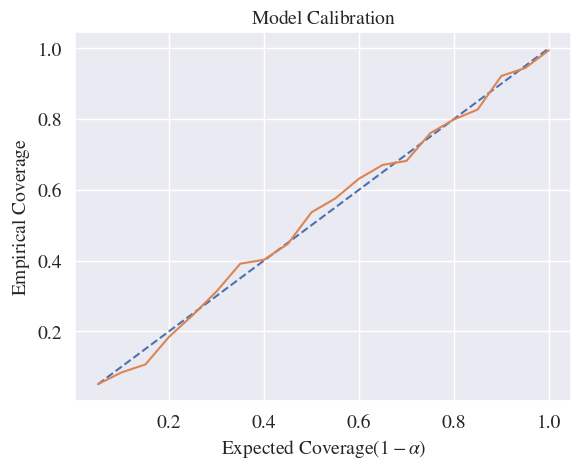

In [22]:
sns.set_theme()

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

alphas = np.arange(0, 1, 0.05)
coverages = []
for alpha in alphas:
    q_hat = np.quantile(cal_scores, q = 1-alpha)
    coverages.append(np.sum(test_scores < q_hat) / N_test)

sns.lineplot(x=(1-alphas), y=(1-alphas), linestyle='--')
sns.lineplot(x=(1-alphas), y=coverages)
plt.xlabel(r"$\mathrm{Expected\ Coverage} (1-\alpha)$")
plt.ylabel(r"$\mathrm{Empirical\ Coverage}$")
plt.title(r"$\mathrm{Model\ Calibration}$")

In [23]:
alpha = 0.05
q_hat = np.quantile(cal_scores, q = 1-alpha)

with open("experiments/airfoil.pkl", "wb") as f:
    pickle.dump({
        "test_C": test_C, 
        "test_C_hat": test_C_hat,
        "q_hat": q_hat,
    }, f)